<a href="https://colab.research.google.com/github/Sunnnyyy16/Dacon_study/blob/main/wine/wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 와인 품질(Quality) 분류 경진대회
사이트: https://dacon.io/competitions/open/235610/overview/description

## 목차

1. 데이터 EDA
2. 데이터 전처리
3. 모델링(Xgboost)
4. 결론

참고
* 데이터 전처리: https://dacon.io/competitions/official/235840/codeshare/3793?page=1&dtype=recent
* 모델링: https://dacon.io/competitions/open/235610/codeshare/4221?page=1&dtype=recent

# 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#경고 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
!cp /gdrive/MyDrive/Dacon_study/Wine/sample_submission.csv ./
!cp /gdrive/MyDrive/Dacon_study/Wine/test.csv ./
!cp /gdrive/MyDrive/Dacon_study/Wine/train.csv ./

In [4]:
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

In [ ]:
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


## null값 확인

In [ ]:
train.isnull().sum()

index                   0
quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64

In [ ]:
test.isnull().sum()

index                   0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64

train, test null값 없음

# 01.데이터 EDA

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64


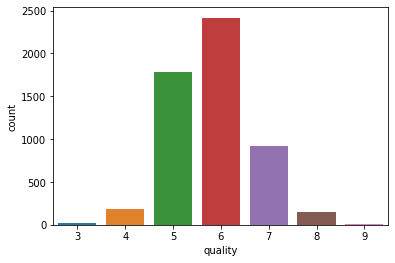

In [ ]:
print(train['quality'].value_counts())
plt.figure()
sns.countplot(x=train['quality'])
plt.show()

6이 제일 많다. 불균형이라 조정 필요할 듯

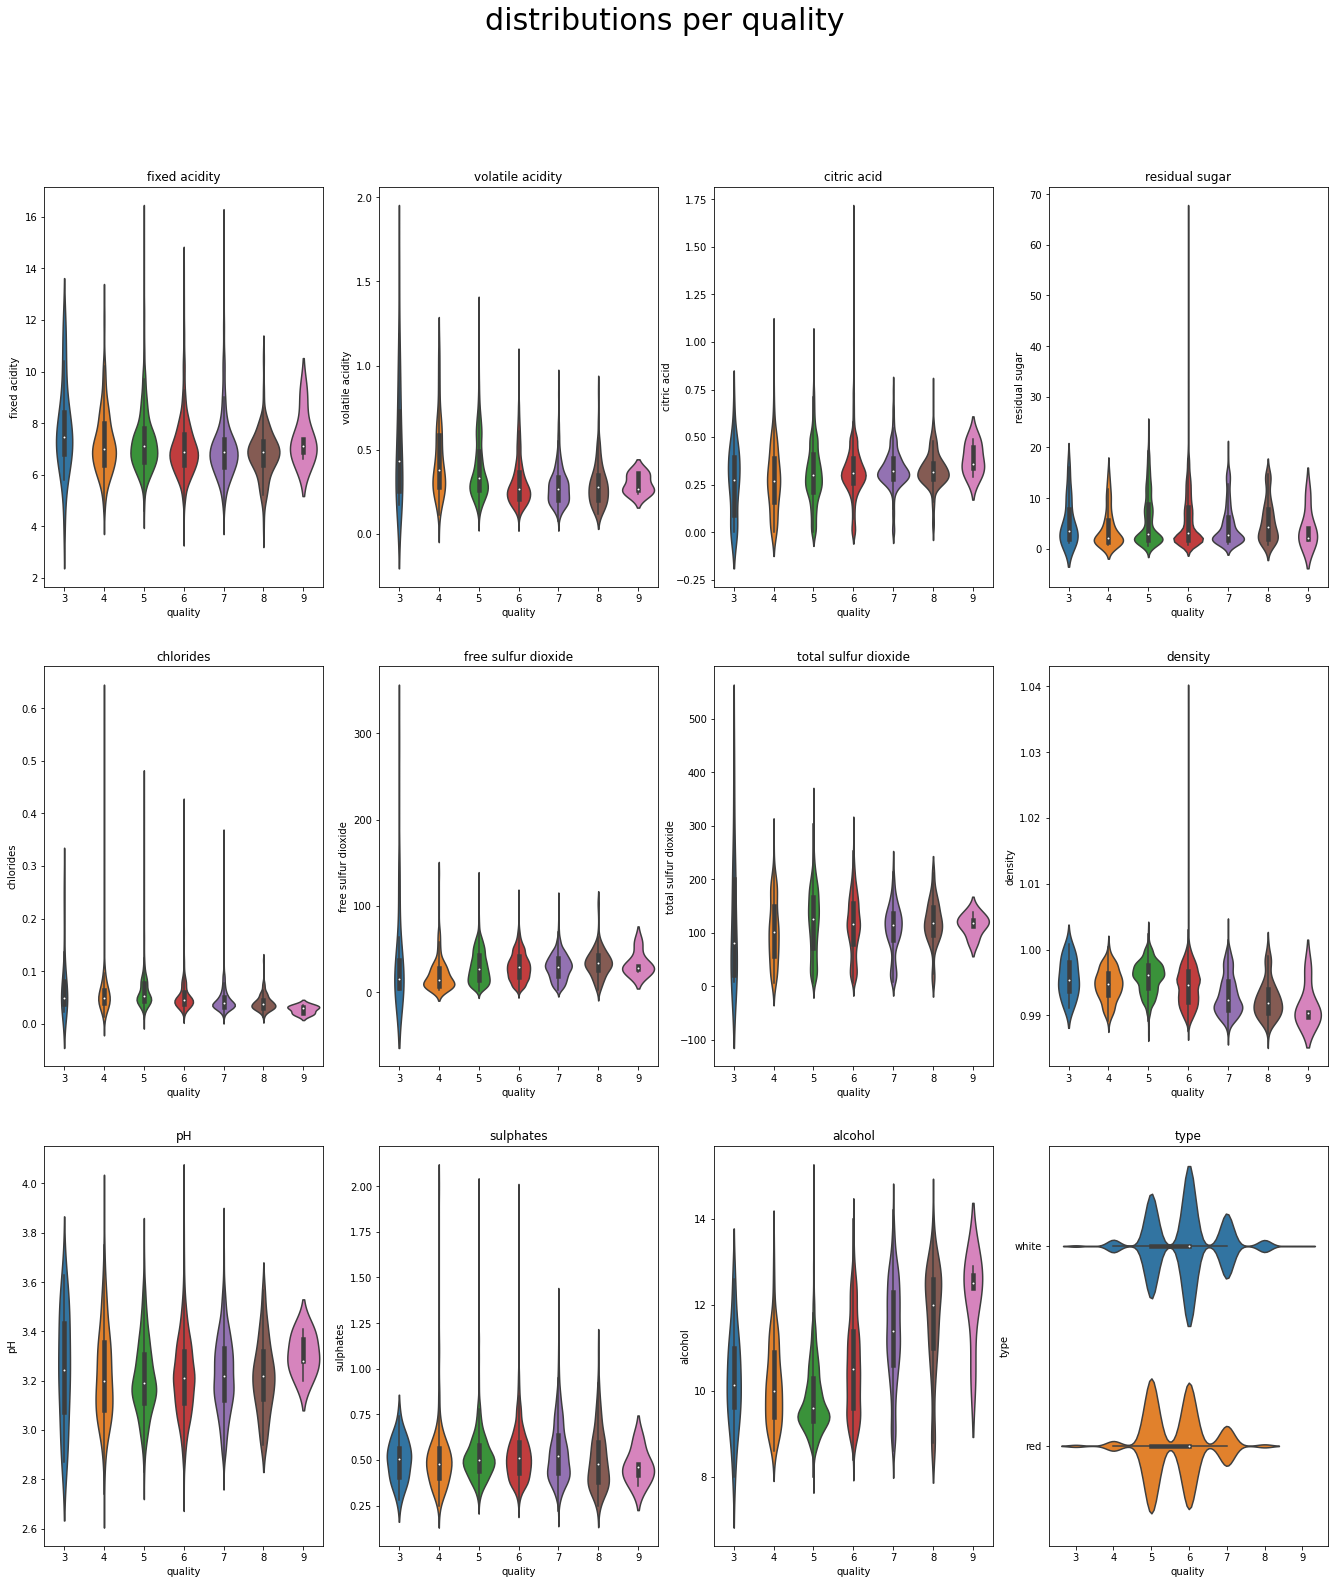

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(23,25))


fig.suptitle('distributions per quality', fontsize= 30)
for ax, col in zip(axs.flat, train.columns[2:]):
  sns.violinplot(x='quality', y=col, ax=ax, data=train)
  ax.set_title(col)

plt.show()

In [ ]:
print(train.columns[1:-2])
print(train.columns)

Index(['quality', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates'],
      dtype='object')
Index(['index', 'quality', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type'],
      dtype='object')


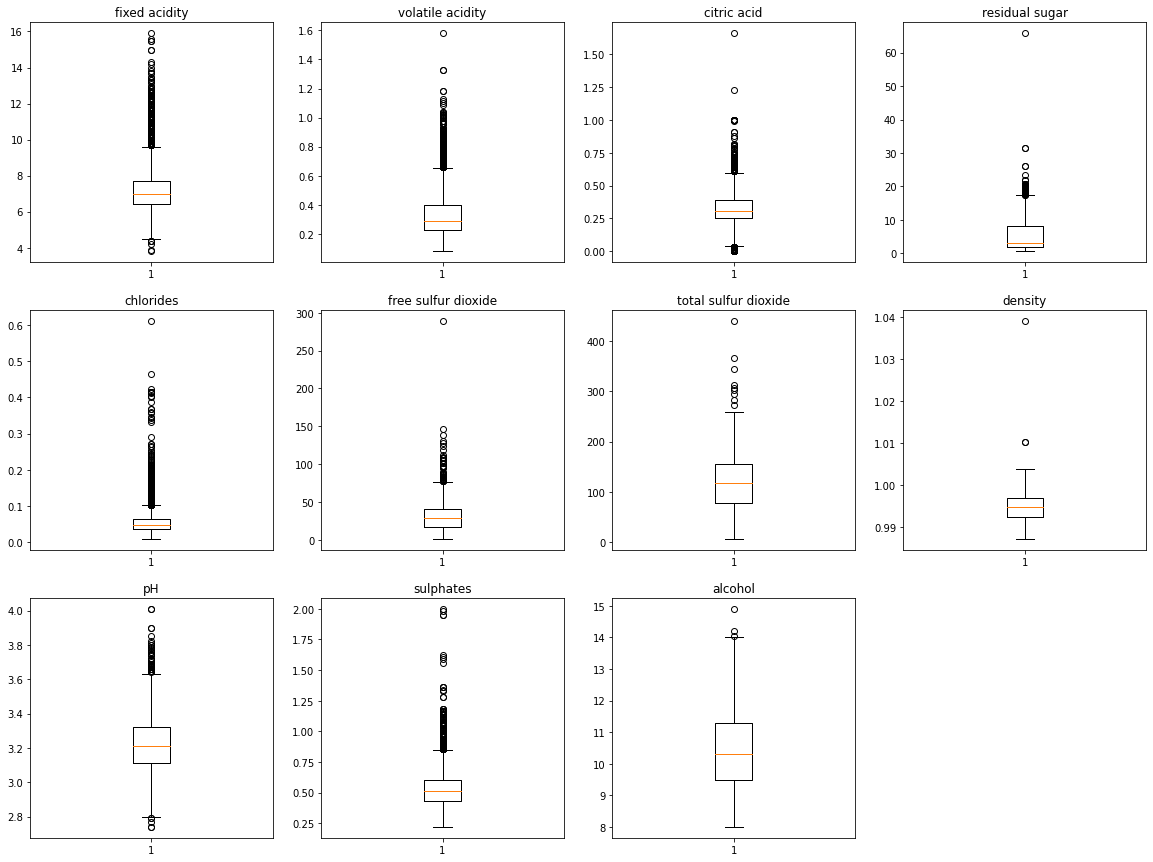

In [ ]:
# boxplot으로 데이터 분포 확인
plt.figure(figsize=(20,15))

cols= train.columns[2:-1]
for i in range(len(cols)):
  plt.subplot(3,4, i+1)
  plt.title(cols[i])
  plt.boxplot(train[cols[i]])
plt.show()

문제점
1. 대부분 column이 많은 이상치(outlier) 가지고 있음. 정규 분포가 아니다.
2. column의 scale이 전부 다르다.

## 상관계수

In [ ]:
train_corr=train.drop(['index'], axis=1)

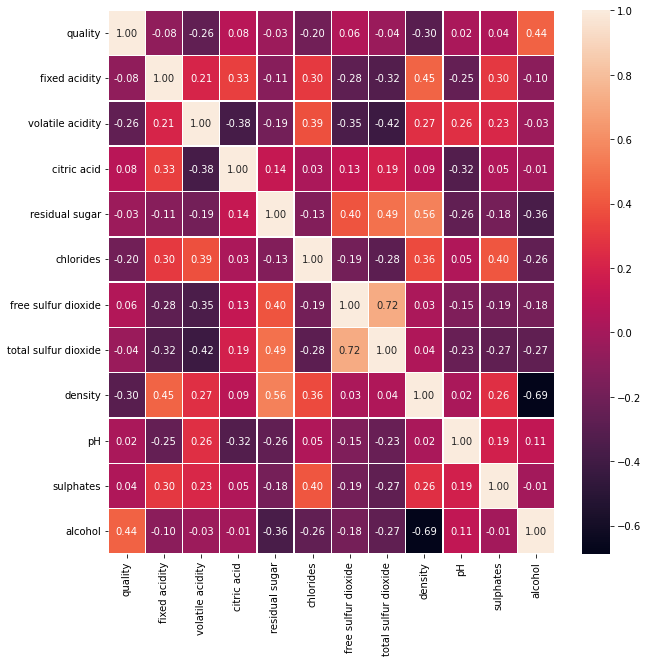

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data = train_corr.corr(), annot=True, fmt = '.2f', linewidths=.5)

# 02.데이터 전처리

In [5]:
#Library
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import plot_roc_curve,accuracy_score, confusion_matrix, plot_confusion_matrix

## Logarithmic Scaling

비정규분포 데이터를 정규분포와 비슷하게 변환해주는 스케일링 방법

In [6]:
def logarithm_scaler(df):
  epsilon = 1e-10
  for i in df.columns:
    if df[i].min() == 0:
      df[i] = np.sqrt(df[i])
    else:
      df[i] = np.log(df[i])
  return df

# 변환 필요 없는 feature는 제외
transform_df= train.drop(columns=['index','type','quality'])

train[transform_df.columns] = logarithm_scaler(transform_df)

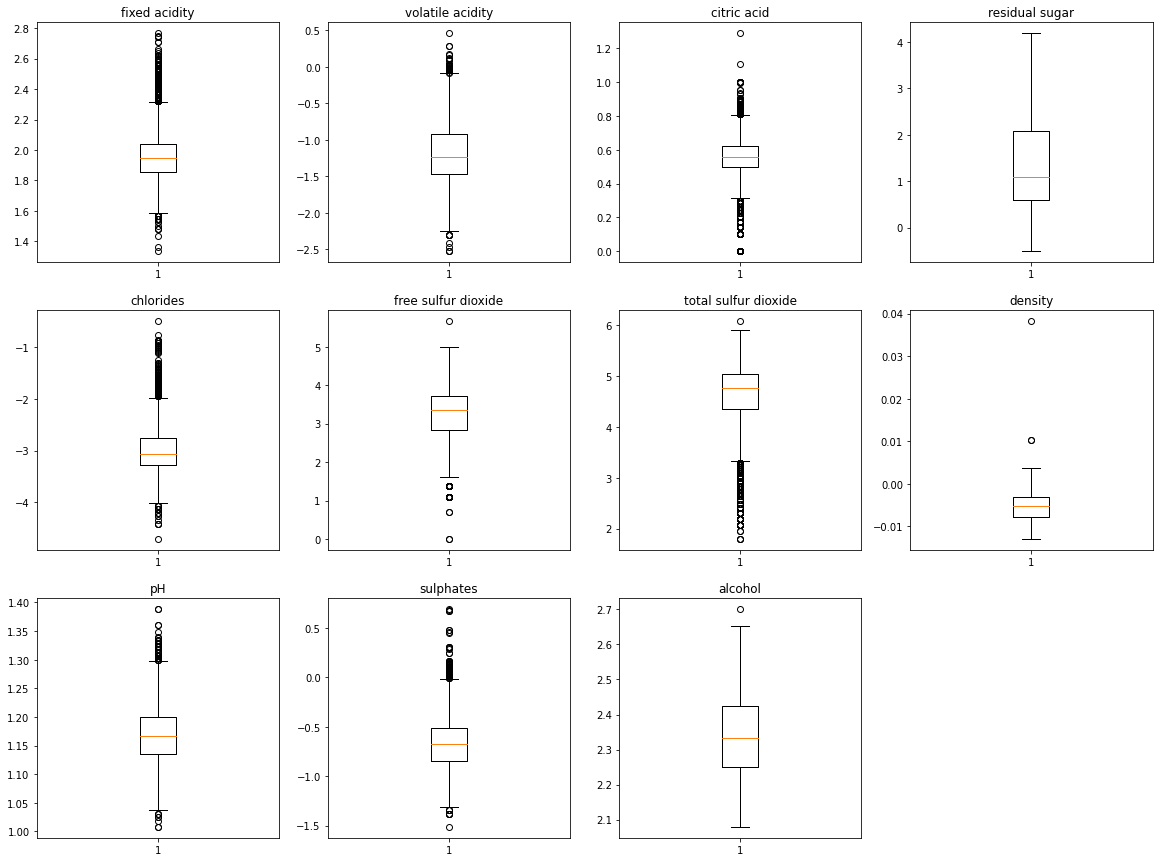

In [ ]:
# boxplot으로 변환 후 데이터 분포 확인
plt.figure(figsize=(20,15))

cols= train.columns[2:-1]
for i in range(len(cols)):
  plt.subplot(3,4, i+1)
  plt.title(cols[i])
  plt.boxplot(train[cols[i]])
plt.show()

## Standard Scaling

column 값들의 단위 통일

In [7]:
#Standard scaler
scaler= StandardScaler()

std_transform_df = scaler.fit_transform(transform_df)
train[transform_df.columns] = std_transform_df
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,-1.458882,1.875542,-1.928347,0.685140,-0.408961,-1.458765,-0.186553,-0.115861,1.360528,-0.594763,-0.207983,white
1,1,5,1.304131,1.577194,-1.091892,-0.521499,0.676778,-1.307548,-1.160554,0.740197,-0.160712,0.547618,-0.846158,red
2,2,5,0.644599,-0.861575,0.528588,-0.732739,0.300993,-0.242694,0.511033,-0.967481,-1.065572,0.055794,0.387816,white
3,3,6,-0.094792,-0.861575,0.090196,0.540125,-0.197469,0.220562,0.166590,-0.255430,0.276932,-0.096943,0.305085,white
4,4,6,0.566725,0.612083,-0.213235,1.072544,0.381167,0.361847,0.868695,0.275945,-1.131786,-0.684291,0.387816,white


## outliers 제거

3 표준편차 이상을 이상치로 판단하고 제거

In [8]:
before_remove = len(train)
# 3 표준편차 이상이면 nan으로 변경
train[transform_df.columns] = np.where(abs(std_transform_df) >3, np.nan, std_transform_df)

# nan 값 제거
train = train.dropna()
print("Removed: - ", before_remove- len(train))

Removed: -  403


## 라벨인코딩

In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['type'])
train['type'] = encoder.transform(train['type'])
test['type'] = encoder.transform(test['type'])

wine type의 str 데이터를 숫자로 변경

## data Augmentation

data imbalance 해결하기

6    2245
5    1649
7     871
4     158
8     150
3      16
9       5
Name: quality, dtype: int64


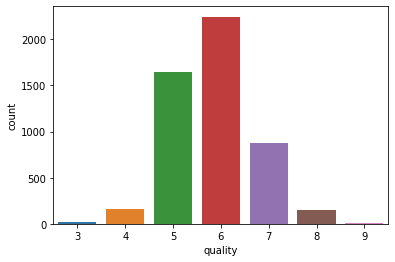

In [ ]:
# data imbalance 정도 확인
print(train['quality'].value_counts())
plt.figure()
sns.countplot(x=train['quality'])
plt.show()

5,6이 많고 3,4,8,9는 심각하게 적음.  

In [10]:
# 수가 적은 class(3,4,8,9) 2배로 늘리기
before_aug = len(train)
train = train.append(train[train['quality'].isin([3,4,8,9])])
print('Augmented: +', len(train)- before_aug)

Augmented: + 329


In [ ]:
 print(train['quality'].value_counts())

6    2416
5    1788
7     924
4     372
8     304
3      52
9      10
Name: quality, dtype: int64


# 03.모델 생성 (Xgboost) 및 학습

### train, val 데이터 split

In [ ]:
X = train.drop(['index','quality'],axis=1)
y = train['quality']

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=.2, random_state=42)

In [ ]:
print(train_x.shape, val_x.shape)

(4325, 12) (1082, 12)


In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(4325, 12)
(4325,)


In [ ]:
train_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
1296,0.161738,-1.090468,-0.150358,1.513507,0.300993,0.851156,0.674275,1.127679,-1.806166,-0.869768,-1.533201,1
3565,0.407935,-1.214121,0.876417,1.154916,0.217955,1.215391,0.480149,0.707058,-0.479234,-0.684291,-0.475951,1
1116,0.407935,-1.214121,1.017321,1.816202,-0.197469,0.530893,0.701213,1.633702,-0.999575,-0.869768,-1.134190,1
1140,0.721494,-0.973159,0.031588,0.887829,-0.703634,0.752135,0.427116,-0.291993,-0.737726,1.042797,1.099963,1
5044,2.266280,-1.344843,0.923882,-1.145986,-0.703634,-2.302377,-1.499431,-0.255430,-2.152008,-2.354923,-0.752165,1


In [ ]:
train_y.head()

1296    8
3565    6
1116    5
1140    6
5044    3
Name: quality, dtype: int64

## 학습

In [ ]:
# 모델링 관련 라이브러리
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_score
import xgboost as xgb

In [ ]:
def Model(model):
    model.fit(train_x,train_y)
    score = model.score(val_x,val_y)
    model_train_score= model.score(train_x,train_y)
    model_test_score=model.score(val_x,val_y)
    prediction = model.predict(val_x)
    cm = confusion_matrix(val_y, prediction)
    print("Testing Score\n", score)
    plot_confusion_matrix(model,val_x,val_y,cmap='OrRd')

4325 1082
Testing Score
 0.621996303142329


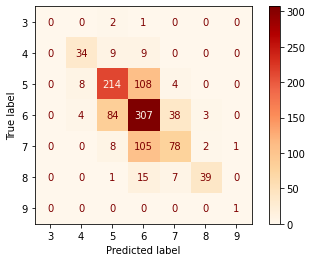

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=500, random_state=42)

print(len(train_x), len(val_x))
xgb_clf.fit(train_x, train_y)
Model(xgb_clf)

1. 전처리 전
  - 0.585
2. 전처리 후
  - 0.622


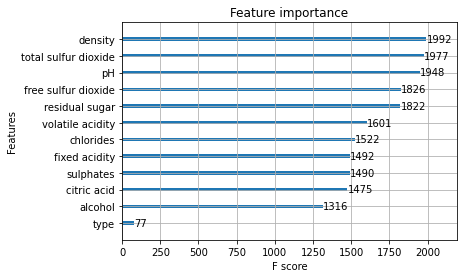

In [ ]:
xgb.plot_importance(xgb_clf)

feature importance를 보면 wine type은 등급 분류에 크게 작용하지 않음. 

## 하이퍼파라미터 튜닝

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42)

In [ ]:
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(train_x, train_y)

print(gridcv.best_params_)

{'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 1}


Testing Score
 0.6802218114602587


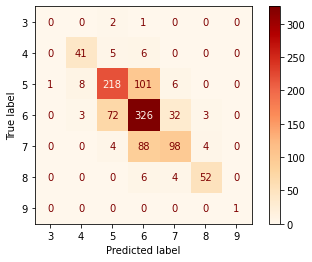

In [ ]:
# 튜닝한 하이퍼파라미터 적용
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=7, min_child_weight=1, colsample_bytree= 0.75)
xgb_clf.fit(train_x, train_y)
Model(xgb_clf)

* 하이퍼 파라미터 튜닝 후 : 0.68

# 모델 생성(LGBM) 및 학습

## train, val 데이터 split

In [ ]:
X = train.drop(['index','quality'],axis=1)
y = train['quality']

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=.2, random_state=42)

In [ ]:
print(train_x.shape, val_x.shape)

(4692, 12) (1174, 12)


In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(4692, 12)
(4692,)


## data imbalace 해결- SMOTE 샘플링

https://acdongpgm.tistory.com/192

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(sampling_strategy='auto', random_state=0)
x_smote, y_smote = sm.fit_resample(train_x, train_y)

In [ ]:
print('After SMOTE OverSampling, the shape of x: {}'.format(x_smote.shape))
print('After SMOTE OverSampling, the shape of y: {} \n'.format(y_smote.shape))

print("After SMOTE OverSampling, counts of label '1': {}".format(y_smote.sum()))
print("After SMOTE OverSampling, counts of label '0': {}".format(len(y_smote)-y_smote.sum()))

After SMOTE OverSampling, the shape of x: (12663, 12)
After SMOTE OverSampling, the shape of y: (12663,) 

After SMOTE OverSampling, counts of label '1': 75978
After SMOTE OverSampling, counts of label '0': -63315


## 학습

In [ ]:
# 모델링 관련 라이브러리
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_score
import lightgbm as lgbm
from lightgbm import LGBMClassifier

In [ ]:
def Model(model):
    model.fit(train_x,train_y)
    score = model.score(val_x,val_y)
    model_train_score= model.score(train_x,train_y)
    model_test_score=model.score(val_x,val_y)
    prediction = model.predict(val_x)
    cm = confusion_matrix(val_y, prediction)
    print("Testing Score\n", score)
    plot_confusion_matrix(model,val_x,val_y,cmap='OrRd')

4692 1174
Testing Score
 0.7223168654173765


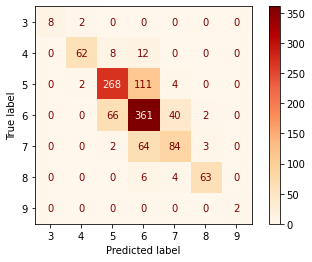

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=500, random_state=42)

print(len(train_x), len(val_x))
lgbm_clf.fit(train_x, train_y)
Model(lgbm_clf)

하이퍼파라미터 튜닝 전 
* 0.72

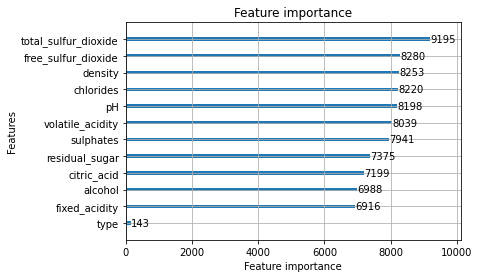

In [ ]:
lgbm.plot_importance(lgbm_clf)

와인 타입은 영향을 거의 주지 않음

Testing Score
 0.7223168654173765


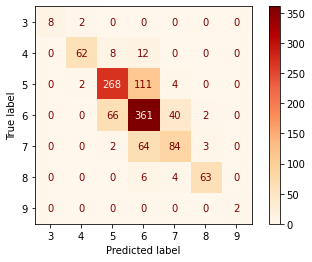

In [ ]:
# SMOTE 적용한 데이터셋 학습
lgbm_clf = LGBMClassifier(n_estimators=500, random_state=42)
lgbm_clf.fit(x_smote, y_smote)
Model(lgbm_clf)

SMOTE 오버샘플링으로 학습 
* 0.72

-> 샘플링 전과 결과 똑같다. 

## 하이퍼파라미터 튜닝

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)

In [ ]:
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(train_x, train_y)

print(gridcv.best_params_)

{'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 1}


Testing Score
 0.7095400340715503


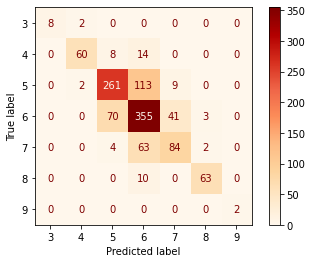

In [ ]:
# 튜닝한 하이퍼파라미터 적용
lgbm_clf = LGBMClassifier(n_estimators=1000, random_state=42, max_depth=7, min_child_weight=1, colsample_bytree= 0.5)
lgbm_clf.fit(train_x, train_y)
Model(lgbm_clf)

하이퍼파라미터 튜닝 후
* 0.71

# 모델 생성(랜덤 포레스트) 및 학습

## train, val 데이터 split

In [ ]:
X = train.drop(['index','quality'],axis=1)
y = train['quality']

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=.2, random_state=42)

## 학습

In [ ]:
# 모델링 관련 라이브러리
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def Model(model):
    model.fit(train_x,train_y)
    score = model.score(val_x,val_y)
    model_train_score= model.score(train_x,train_y)
    model_test_score=model.score(val_x,val_y)
    prediction = model.predict(val_x)
    cm = confusion_matrix(val_y, prediction)
    print("Testing Score\n", score)
    plot_confusion_matrix(model,val_x,val_y,cmap='OrRd')

4338 1085
Testing Score
 0.719815668202765


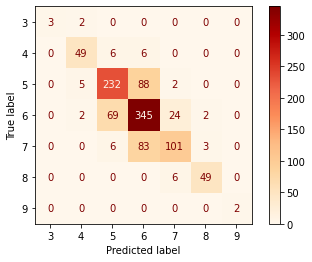

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state= 42)

print(len(train_x), len(val_x))
rf_clf.fit(train_x, train_y)
Model(rf_clf)

하이퍼파라미터 튜닝 전 랜덤포레스트 : 0.72

# 모델 생성(SVM) 및 학습

## train,val 데이터 split

In [ ]:
X = train.drop(['index','quality'],axis=1)
y = train['quality']

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=.2, random_state=42)

## 학습

In [ ]:
# 모델링 관련 라이브러리
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_score, confusion_matrix, classification_report
from sklearn import svm

In [ ]:
def Model(model):
    model.fit(train_x,train_y)
    score = model.score(val_x,val_y)
    model_train_score= model.score(train_x,train_y)
    model_test_score=model.score(val_x,val_y)
    prediction = model.predict(val_x)
    cm = confusion_matrix(val_y, prediction)
    print("Testing Score\n", score)
    plot_confusion_matrix(model,val_x,val_y,cmap='OrRd')

4338 1085
Testing Score
 0.4930875576036866


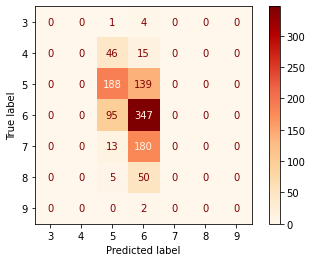

In [ ]:
svm_clf = svm.SVC(kernel='linear')

print(len(train_x), len(val_x))
svm_clf.fit(train_x, train_y)
Model(svm_clf)

In [ ]:
svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(train_x, train_y)

y_pred = svm_clf.predict(val_x)

svm_accuracy = accuracy_score(val_y,y_pred)
print('SVM 정확도: ', svm_accuracy)

svm_report = classification_report(val_y, y_pred)
print(svm_report)

# svm_matrix = confusion_matrix(val_y, y_pred)
# print(svm_matrix)

SVM 정확도:  0.4930875576036866
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        61
           5       0.54      0.57      0.56       327
           6       0.47      0.79      0.59       442
           7       0.00      0.00      0.00       193
           8       0.00      0.00      0.00        55
           9       0.00      0.00      0.00         2

    accuracy                           0.49      1085
   macro avg       0.14      0.19      0.16      1085
weighted avg       0.35      0.49      0.41      1085



# 제출

In [ ]:
# 테스트셋 로그 변환 과정
transform_test = test.drop(columns=['index','type', 'total sulfur dioxide']) 
test[transform_test.columns] = logarithm_scaler(transform_test)

# Scaling 과정
transform_tests = test.drop(columns=['index','type']) 
std_transform_tests = scaler.transform(transform_tests)
test[transform_tests.columns] = std_transform_tests

# Text labeling 과정
word_to_num = {"white":0, "red":1}
test['type'] = test['type'].replace(word_to_num)

In [ ]:
# 예측
prediction = lgbm_clf.predict(test.drop('index', axis=1))

In [ ]:
submission= pd.read_csv('sample_submission.csv')
submission['quality'] = prediction

# 예측 결과가 잘 만들어졌는지 확인
submission.head()

,index,quality
0,0,5
1,1,5
2,2,5
3,3,6
4,4,6


In [ ]:
# submission을 csv 파일로 저장.

submission.to_csv("submission.csv", index=False)

# 결론

1차 제출 데이콘 스코어: 0.557

* 개선 방안
1. 차원축소로 column 수 줄이기
2. data imbalance 해결 (augmentation했지만 아직도 불균형하다)
3. XGBoost 말고 다른 모델 사용

2차 제출 데이콘 스코어: 0.558

* 개선 방안
1. 차원축소
2. LGBM 말고 다른 모델